# Proyecto Series Temporales
### Grupo 8 - Walmart Sales
#### Integrantes:

- Diego Collado
- Iñigo Gonzalez-Varas
- Carlota Lopez
- Diego Lopez



Este trabajo trata de predecir las ventas semanales de Walmart.

Importamos las librerías necesarias para el trabajo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')

## Exploración preliminar de los datos

In [2]:
train_set = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

Train set: 5 columnas
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- Weekly_Sales: ventas semanales (date->date+7)
- IsHoliday: si la semana contiene un dia festivo

In [3]:
train_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Stores set: 3 columnas
- Store: número de tienda
- Type: tipo de tienda (se asigna una letra dependiendo del tamaño de la tienda)
- Size: tamaño de la tienda

In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Features set: 12 columnas
- Store: número de tienda
- Date: fecha de inicio de la semana
- Temperature: temperatura media durante la semana en la región donde está ubicada la tienda (Fahrenheit)
- Fuel_Price: precio medio del combustible en la zona donde está ubicada la tienda
- MarkDown1-5: datos anónimos relacionados con promociones. Esta información está disponible solo para algunas tiendas y para algunas fechas.
- CPI: índice de precios al consumo (Consumer Price Index). 
- Unemployment: tasa de desempleo
- IsHoliday: si la semana contiene un dia festivo


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Test set: 4 columnas (subconjunto de train)
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- IsHoliday: si la semana contiene un dia festivo


In [6]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Conclusiones de la exploración preliminar

Con estos datos, vamos a tratar de predecir las ventas semanales de walmart agrupadas por tienda y departamento. 
En primer lugar, desarrollamos un modelo que únicamente tenga como input la serie temporal de ventas e intente prdecir las ventas futuras. 
Una vez veamos cómo funciona este modelo, añadiremos más variables (exógenas) para ver si podemos mejorar la predicción.

## Tratamiento de datos

In [7]:
total_sales = train_set.groupby('Date')['Weekly_Sales'].sum().reset_index()
total_sales['Date'] = pd.to_datetime(total_sales['Date'])
total_sales

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


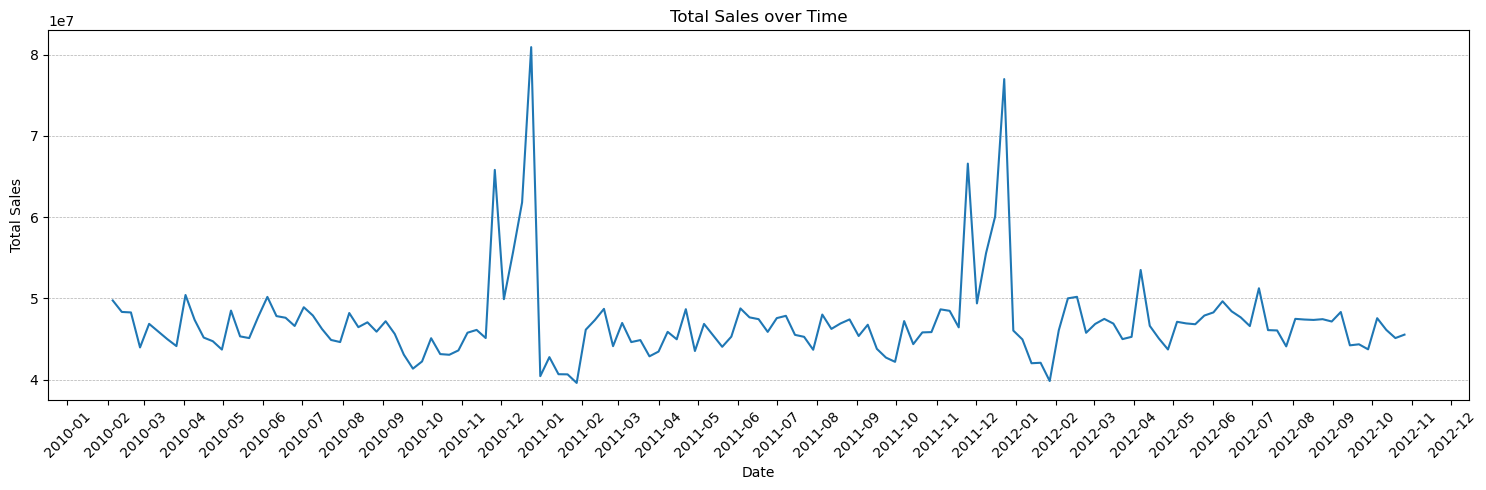

In [8]:
# Plotting the total sales over time
plt.figure(figsize=(15, 5))
plt.plot(total_sales['Date'], total_sales['Weekly_Sales'])
locator = mdates.MonthLocator()  
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales over Time')
plt.xticks(rotation=45)  # Rotate the x-ticks for better visibility
plt.tight_layout()  # Ensure layout is neat and no labels are cut off
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [9]:
df = train_set.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [10]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

vamos a ver el numero de ventas semanales de cada tienda dividido por el numero de ventas de cada dept

In [11]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table.head(10))

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


viendo la grafica podemos ver que hay valores negativos nan etc asi que habra que eliminarlos si no suponen un cambio de datos muy grande

In [12]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [13]:
df = df.loc[df['Weekly_Sales'] > 0]

In [14]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221


<Axes: >

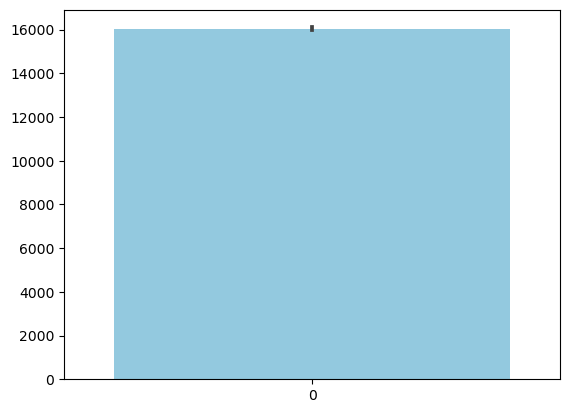

In [15]:
sns.barplot(df['Weekly_Sales'], color="skyblue")

vamos a ver si hay valores nulos

In [16]:
df['Weekly_Sales'].isna().sum()

0

In [17]:
df['Weekly_Sales'].describe()

count    420212.000000
mean      16033.114591
std       22729.492116
min           0.010000
25%        2120.130000
50%        7661.700000
75%       20271.265000
max      693099.360000
Name: Weekly_Sales, dtype: float64

vamos a ver si el numero de ventas aumenta cuando es vacaciones

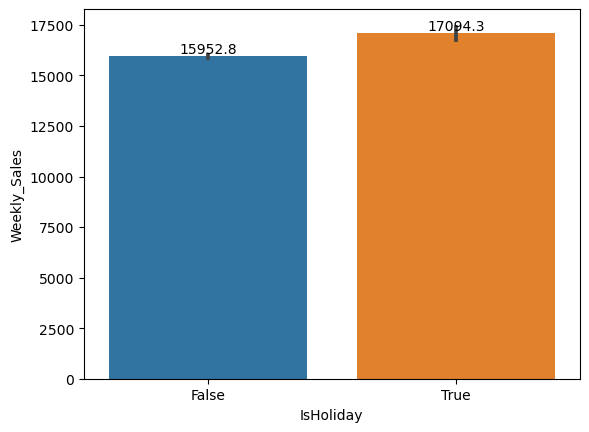

In [18]:
ax = sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)
for i in ax.containers:
    ax.bar_label(i,)


deberiamos: hacer el decomp de la primera practica
hacer unos lag como en la segunda
sacarnos las correlaciones

In [19]:
# Crear los lags de ventas
lags = 10  # Número de lags
for i in range(1, lags + 1):
    df[f"lag_{i}"] = df["Weekly_Sales"].shift(i)

# Eliminar filas con valores faltantes en las nuevas columnas de lag
df.dropna(subset=[f"lag_{i}" for i in range(1, lags + 1)], inplace=True)

# Definir las características (lags) y la variable objetivo








In [20]:
X = df[[f"lag_{i}" for i in range(1, lags + 1)]]
y = df["Weekly_Sales"]
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
10,30721.50,16930.99,40129.01,21084.08,5749.03,32229.38,39954.04,13740.12,50605.27,24924.50
11,24213.18,30721.50,16930.99,40129.01,21084.08,5749.03,32229.38,39954.04,13740.12,50605.27
12,8449.54,24213.18,30721.50,16930.99,40129.01,21084.08,5749.03,32229.38,39954.04,13740.12
13,41969.29,8449.54,24213.18,30721.50,16930.99,40129.01,21084.08,5749.03,32229.38,39954.04
14,19466.91,41969.29,8449.54,24213.18,30721.50,16930.99,40129.01,21084.08,5749.03,32229.38
...,...,...,...,...,...,...,...,...,...,...
421565,54608.75,16330.84,25352.32,8187.66,1689.10,717.82,17360.33,14693.09,670.88,14618.60
421566,2487.80,54608.75,16330.84,25352.32,8187.66,1689.10,717.82,17360.33,14693.09,670.88
421567,5203.31,2487.80,54608.75,16330.84,25352.32,8187.66,1689.10,717.82,17360.33,14693.09
421568,56017.47,5203.31,2487.80,54608.75,16330.84,25352.32,8187.66,1689.10,717.82,17360.33


In [21]:
# Dividir los datos en conjuntos de entrenamiento y prueba
Xaux = X[200000:200500]
yaux = y[200000:200500]
Xaux.shape


(500, 10)

In [22]:
plt.rcParams['agg.path.chunksize'] = 200
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=5)  # Puedes ajustar la profundidad máxima según tus necesidades
modelo_arbol.fit(X, y)
predicciones = modelo_arbol.predict(Xaux)

In [23]:
predicciones.shape

(500,)

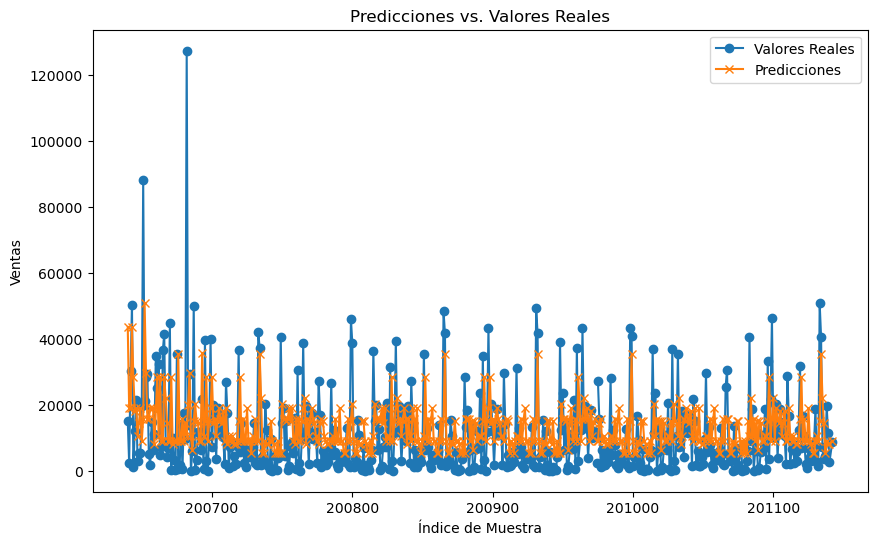

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(yaux.index,yaux, label='Valores Reales', marker='o')
plt.plot(yaux.index,predicciones, label='Predicciones', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')
plt.legend()
plt.show()